In [48]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/uplift-modeling/baseline.csv
/kaggle/input/uplift-modeling/products.csv
/kaggle/input/uplift-modeling/clients2.csv
/kaggle/input/uplift-modeling/train.csv
/kaggle/input/uplift-modeling/test.csv
/kaggle/input/uplift-modeling/test_purch.csv
/kaggle/input/uplift-modeling/train_purch.csv


In [49]:
import sys

# install uplift library scikit-uplift and other libraries 
!{sys.executable} -m pip install scikit-uplift catboost pandas

import gc
import pandas as pd
import numpy as np
import xgboost as xgb
from datetime import datetime
from sklearn.metrics import accuracy_score

from hyperopt import STATUS_OK, Trials, fmin, hp, tpe

from xgboost import XGBClassifier
from xgboost import cv
from lightgbm import LGBMClassifier

from sklift.models import ClassTransformation
from sklift.metrics import uplift_at_k
from sklift.metrics import qini_auc_score

import matplotlib.pyplot as plt

%matplotlib inline

# 1. Data Understanding

In [50]:
# Import initial data

df_clients = pd.read_csv(
    '/kaggle/input/uplift-modeling/clients2.csv', 
    index_col='client_id', 
    parse_dates=['first_issue_date', 'first_redeem_date']
)

df_train_purchases = pd.read_csv(
    '/kaggle/input/uplift-modeling/train_purch.csv',
    index_col='client_id', 
    parse_dates=['transaction_datetime']
)


df_test_purchases = pd.read_csv(
    '/kaggle/input/uplift-modeling/test_purch.csv',
    index_col='client_id', 
    parse_dates=['transaction_datetime']
)


df_purchases = pd.concat([
    df_train_purchases, 
    df_test_purchases
])


df_train = pd.read_csv('/kaggle/input/uplift-modeling/train.csv', index_col='client_id')
df_test = pd.read_csv('/kaggle/input/uplift-modeling/test.csv', index_col='client_id')

In [51]:
df_clients.head()

,client_id.1,first_issue_date,first_redeem_date,age,gender
client_id,,,,,
000012768d,NaN,2017-08-05 15:40:48,2018-01-04 19:30:07,45,U
000036f903,NaN,2017-04-10 13:54:23,2017-04-23 12:37:56,72,F
00010925a5,NaN,2018-07-24 16:21:29,2018-09-14 16:12:49,83,U
0001f552b0,NaN,2017-06-30 19:20:38,2018-08-28 12:59:45,33,F
00020e7b18,NaN,2017-11-27 11:41:45,2018-01-10 17:50:05,73,U


In [52]:
df_clients.isnull().mean()*100

client_id.1          100.00000
first_issue_date       0.00000
first_redeem_date      8.77129
age                    0.00000
gender                 0.00000
dtype: float64

In [53]:
df_purchases.head()

,transaction_id,transaction_datetime,regular_points_received,express_points_received,regular_points_spent,express_points_spent,purchase_sum,store_id,product_id,product_quantity,trn_sum_from_iss,trn_sum_from_red
client_id,,,,,,,,,,,,
000012768d,7e3e2e3984,2018-12-01 07:12:45,10.0,0.0,0.0,0.0,1007.0,54a4a11a29,9a80204f78,2.0,80.0,NaN
000012768d,7e3e2e3984,2018-12-01 07:12:45,10.0,0.0,0.0,0.0,1007.0,54a4a11a29,da89ebd374,1.0,65.0,NaN
000012768d,7e3e2e3984,2018-12-01 07:12:45,10.0,0.0,0.0,0.0,1007.0,54a4a11a29,0a95e1151d,1.0,24.0,NaN
000012768d,7e3e2e3984,2018-12-01 07:12:45,10.0,0.0,0.0,0.0,1007.0,54a4a11a29,4055b15e4a,2.0,50.0,NaN
000012768d,7e3e2e3984,2018-12-01 07:12:45,10.0,0.0,0.0,0.0,1007.0,54a4a11a29,a685f1916b,1.0,22.0,NaN


In [54]:
df_purchases.isnull().mean()*100

transaction_id              0.00000
transaction_datetime        0.00000
regular_points_received     0.00000
express_points_received     0.00000
regular_points_spent        0.00000
express_points_spent        0.00000
purchase_sum                0.00000
store_id                    0.00000
product_id                  0.00000
product_quantity            0.00000
trn_sum_from_iss            0.00000
trn_sum_from_red           93.38628
dtype: float64

In [55]:
df_train.head()

,treatment_flg,purchased
client_id,,
ad6561e2d8,1,1
7c1ccbf93f,1,1
b58fadcab6,1,1
e99e6fabb9,0,0
27fb6f8520,1,1


In [56]:
df_train.isnull().mean()*100

treatment_flg    0.0
purchased        0.0
dtype: float64

In [57]:
df_test.head()

""
client_id
a9a604ed6e
ebd7360016
908cd9b8e8
dceb8ce861
f4f0ac6b06


In [58]:
df_test.isnull().mean()*100

Series([], dtype: float64)

# 3. Data Preparetion

In [59]:
# Cleaning data
del df_clients["client_id.1"]
del df_purchases["trn_sum_from_red"]
df_clients = df_clients.dropna()

In [60]:
# Convert datetime to integer

df_clients.loc[:,'first_redeem_date'] =\
    df_clients.loc[:,'first_redeem_date']\
        .fillna(datetime(2019, 3, 19, 0, 0))

df_clients.loc[:, 'first_redeem_date'] =\
    ((df_clients['first_redeem_date'] - pd.Timestamp("1970-01-01")) // pd.Timedelta('1d'))

df_clients.loc[:,'first_issue_date'] =\
    df_clients.loc[:,'first_issue_date']\
        .fillna(datetime(2019, 3, 19, 0, 0))

df_clients.loc[:, 'first_issue_date'] =\
    ((df_clients['first_issue_date'] - pd.Timestamp("1970-01-01")) // pd.Timedelta('1d'))

In [61]:
# Aggregate df_purchases data

# Aggregate to (client, transaction) take one row only 
# Aggregate all transactions to client.

df_purch = df_purchases\
    .groupby(['client_id','transaction_id'])[['express_points_spent', 'purchase_sum']]\
    .last()\
    .groupby('client_id')\
    .agg({
        'express_points_spent': ['mean', 'sum'], 
        'purchase_sum': ['sum']
    })
    
df_purch.columns =\
    ['express_spent_mean', 'express_points_spent_sum', 'purchase_sum__sum']

In [62]:
reg_points_last_m = df_purchases[
        df_purchases['transaction_datetime'] > '2019-02-18'
    ]\
    .groupby(['client_id', 'transaction_id'])['regular_points_received']\
    .last()\
    .groupby('client_id')\
    .sum()
    
reg_points_last_m = pd.DataFrame({
    'regular_points_received_sum_last_m': reg_points_last_m  
})

In [63]:
# Make 'transaction_datetime' from purchases data frame as integer.
df_purchases.loc[:,'purch_day'] =\
     ((df_purchases['transaction_datetime'] - pd.Timestamp("1970-01-01")) // pd.Timedelta('1d'))

In [64]:
# Calculate features from purchases data for all transactions after redeem date:

df_purch_joined = pd.merge(
    df_purchases[
        ['purch_day', 'transaction_id', 'purchase_sum']
    ],
    df_clients\
    .reset_index()[
        ['client_id', 'first_redeem_date']
    ], on='client_id', how='left')

df_purch_joined = df_purch_joined\
    .assign(date_diff=\
        df_purch_joined['first_redeem_date'] - df_purch_joined['purch_day']
)

df_purch_agg = df_purch_joined[
        df_purch_joined['date_diff'] <= 0
    ]\
    .groupby(
        ['client_id', 'transaction_id']
    )\
    .last()\
    .groupby('client_id')['purchase_sum']\
    .sum()
    
after_redeem_sum = pd.DataFrame(data={
    'after_redeem_sum': df_purch_agg
})

del df_purch_joined, df_purch_agg
gc.collect();

In [65]:
# 'purch_delta' - difference in days between last and first transaction

df_purch_delta_agg = df_purchases\
    .groupby('client_id')\
      .agg({
          'purch_day': ['max', 'min']
      })

df_purch_delta = pd.DataFrame(
    data=df_purch_delta_agg['purch_day']['max'] -\
        df_purch_delta_agg['purch_day']['min'] + 1,
    columns=['purch_delta']
)

del df_purch_delta_agg
gc.collect();

In [66]:
# Concatinate all data together

df_feats = pd.concat([
    df_clients[['first_redeem_date']], 
    df_purch, 
    df_purch_delta, 
    reg_points_last_m, 
    after_redeem_sum
], axis=1, sort=False)

df_feats = df_feats\
    .assign(
        avg_spent_perday=\
            df_feats['purchase_sum__sum'] / df_feats['purch_delta'],
        after_redeem_sum_perday =\
            df_feats['after_redeem_sum'] / df_feats['purch_delta']
    )\
    .drop([
        'purch_delta', 'purchase_sum__sum', 'after_redeem_sum'
    ], axis=1
    )

In [67]:
df_feats.isnull().mean()*100

first_redeem_date                      8.771290
express_spent_mean                     0.000000
express_points_spent_sum               0.000000
regular_points_received_sum_last_m     0.000000
avg_spent_perday                       0.000000
after_redeem_sum_perday               20.069586
dtype: float64

In [68]:
# Train and test features
print(df_feats.shape)
df_feats.head(5)

(200039, 6)


,first_redeem_date,express_spent_mean,express_points_spent_sum,regular_points_received_sum_last_m,avg_spent_perday,after_redeem_sum_perday
client_id,,,,,,
000012768d,17535.0,0.000000,0.0,10.0,26.951923,26.951923
000036f903,17279.0,0.000000,0.0,13.7,89.136364,89.136364
00010925a5,17788.0,0.000000,0.0,13.9,56.567308,56.567308
0001f552b0,17771.0,0.000000,0.0,47.0,54.470619,54.470619
00020e7b18,17541.0,-1.666667,-30.0,58.4,228.492124,228.492124


In [69]:
# Make train and test data: join clints ids and treatment and target for train

df_train_feats = df_train\
    .join(
        df_feats, 
        how='left'
    )
    
df_test_feats = df_test\
    .join(
        df_feats, 
        how='left'
    )

In [70]:
X=df_train_feats\
        .drop(
            ['treatment_flg', 'purchased'], 
            axis=1
        )
y=df_train_feats['purchased']

# 4. Modeling

In [71]:
# Tuning Hyper parametrs

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test, treatment_train, treatment_test = train_test_split( X, y, df_train_feats['treatment_flg'], test_size = 0.3, random_state = 0)

In [72]:
# Initialize domain space

space={'max_depth': hp.quniform("max_depth", 1, 2, 1),
        'gamma': hp.uniform ('gamma', 1,2),
        'reg_alpha' : hp.quniform('reg_alpha', 1,10,1),
        'reg_lambda' : hp.uniform('reg_lambda', 0,1),
        'colsample_bytree' : hp.uniform('colsample_bytree', 0.5,1),
        'min_child_weight' : hp.quniform('min_child_weight', 0, 10, 1),
        'learning_rate' : hp.quniform('learning_rate', 0.05, 0.3, 0.025),
        'n_estimators': hp.quniform('n_estimators', 50, 300, 10)
    }

In [73]:
# Define objective function

def objective(space):
    clf=xgb.XGBClassifier(
        max_depth = int(space['max_depth']), gamma = space['gamma'],
        reg_alpha = int(space['reg_alpha']), reg_lambda = space['reg_lambda'],
        colsample_bytree=space['colsample_bytree'],
        min_child_weight=int(space['min_child_weight']),
        learning_rate=space['learning_rate'],
        n_estimators =int(space['n_estimators'] 
    ))
    
    evaluation = [( X_train, y_train), ( X_test, y_test)]
    
    clf.fit(X_train, y_train,
            eval_set=evaluation, eval_metric="auc",
            verbose=False)
    
    pred = clf.predict(X_test)
    accuracy = accuracy_score(y_test, pred>0.5)
    
    print ("SCORE:", accuracy)
    return {'loss': -accuracy, 'status': STATUS_OK }

In [74]:
"""trials = Trials()

best_hyperparams = fmin(fn = objective,
                        space = space,
                        algo = tpe.suggest,
                        max_evals = 100,
                        trials = trials)

print("The best hyperparameters are : ","\n")
print(best_hyperparams)"""

'trials = Trials()\n\nbest_hyperparams = fmin(fn = objective,\n                        space = space,\n                        algo = tpe.suggest,\n                        max_evals = 100,\n                        trials = trials)\n\nprint("The best hyperparameters are : ","\n")\nprint(best_hyperparams)'

In [89]:
# Uplift class tranformation approach for uplift prediction with XGBoost as an estimator

xgb_est_params = {
    #'colsample_bytree': 0.51,
    #'gamma': 1.04,
    #'min_child_weight': 1,
    #'reg_alpha': 5.0,
    #'reg_lambda': 0.013,
    'max_depth':2,
    'learning_rate': 0.2, 
    'n_estimators': 110,
    'seed' : 42,
    'eval_metric' : 'auc'
}

estimator = XGBClassifier(
    **xgb_est_params
)

uplift_model_cl_tr = ClassTransformation(
    estimator=estimator
)

In [90]:
# Fit model on all train data

uplift_model_cl_tr.fit(X, y, df_train_feats['treatment_flg'])

ClassTransformation(estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                            colsample_bylevel=1,
                                            colsample_bynode=1,
                                            colsample_bytree=1,
                                            eval_metric='auc', gamma=0,
                                            gpu_id=-1, importance_type='gain',
                                            interaction_constraints='',
                                            learning_rate=0.2, max_delta_step=0,
                                            max_depth=2, min_child_weight=1,
                                            missing=nan,
                                            monotone_constraints='()',
                                            n_estimators=110, n_jobs=4,
                                            num_parallel_tree=1,
                                            random_state=42, reg_alpha=0,
         

In [86]:
# Make predictions on whole train and test sets
uplift_tr = uplift_model_cl_tr.predict(
    df_train_feats\
        .drop(['treatment_flg', 'purchased'], axis=1),
)

uplift_ts = uplift_model_cl_tr.predict(
    df_test_feats
)

# 5.Evaluation

In [78]:
# Cross Validation
#Train data

data_dmatrix = xgb.DMatrix(data=X_train,label=y_train) # define data_dmatrix

xgb_cvtrain = cv(dtrain=data_dmatrix, params=xgb_est_params, nfold=2,
                    num_boost_round=500, metrics="auc", early_stopping_rounds= 10,as_pandas=True)

xgb_cvtrain['test-auc-mean'].max()

#Test data

data_dmatrix = xgb.DMatrix(data=X_test,label=y_test) # define data_dmatrix

xgb_cvtest = cv(dtrain=data_dmatrix, params=xgb_est_params, nfold=3,
                    num_boost_round=500, metrics="auc", early_stopping_rounds= 10,as_pandas=True)

xgb_cvtest['test-auc-mean'].max()

#All data

data_dmatrix = xgb.DMatrix(data=X,label=y) # define data_dmatrix

xgb_cv = cv(dtrain=data_dmatrix, params=xgb_est_params, nfold=2,
                    num_boost_round=500, metrics="auc", early_stopping_rounds= 10,as_pandas=True)

xgb_cv['test-auc-mean'].max()

[13:37:54] WARNING: ../src/learner.cc:573: 
Parameters: { "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13:37:54] WARNING: ../src/learner.cc:573: 
Parameters: { "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13:38:08] WARNING: ../src/learner.cc:573: 
Parameters: { "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


0.7178329999999999

In [91]:
df_train_scores = df_train_feats[['treatment_flg', 'purchased']]\
    .assign(uplift_score=uplift_tr)

df_submit = df_test_feats\
    .assign(uplift=uplift_ts)[['uplift']]

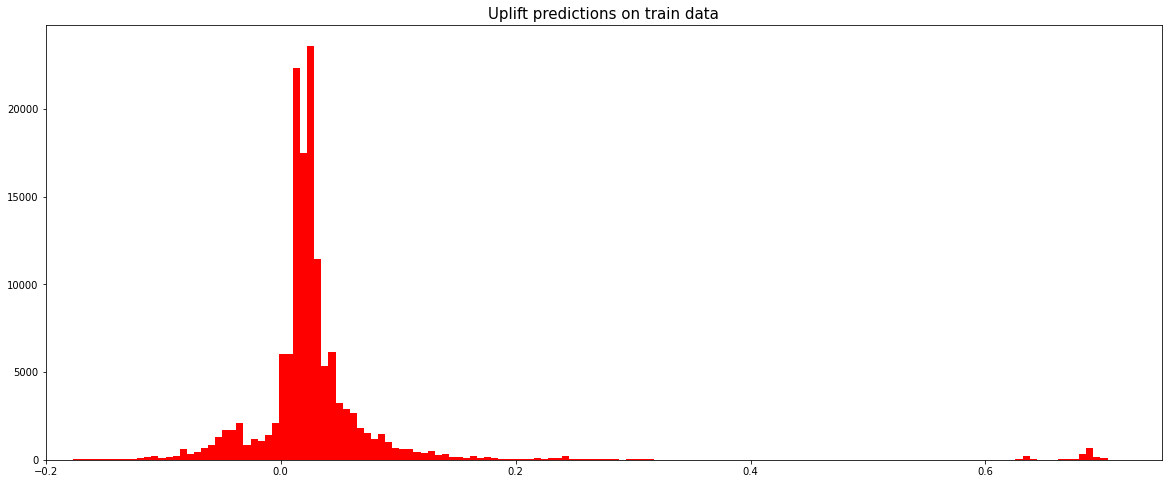

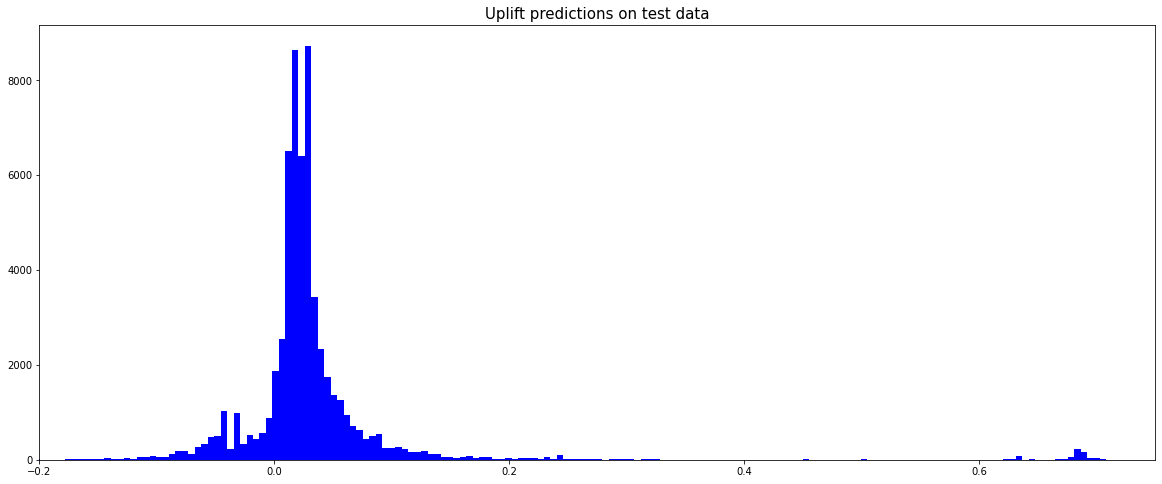

In [92]:
# Plot uplift prediction for test and train data

plt.figure(figsize=(20, 8));

plt.hist(
    df_train_scores['uplift_score'],
    bins=200, 
    color='red', 
);

plt.xlim(-0.2, 0.75);
plt.title('Uplift predictions on train data', size=15);


plt.figure(figsize=(20, 8));

plt.hist(
    df_submit['uplift'],
    bins=200, 
    color='blue', 
);

plt.xlim(-0.2, 0.75);
plt.title('Uplift predictions on test data', size=15);

In [81]:
df_submit_pred=df_submit+50
df_submit_pred.rename(columns={'uplift':'pred'}, inplace=True)
df_submit_pred.to_csv('/kaggle/working/submit_pred.csv')

In [93]:
# Feature importance
df_feat_imp = pd.DataFrame([
    uplift_model_cl_tr\
        .estimator\
        .get_booster()\
        .get_score(importance_type='gain')
        ]
).T.reset_index()

df_feat_imp.columns =\
    ["feature", "value"]
    
df_feat_imp\
    .sort_values('value', ascending=False)

,feature,value
0,first_redeem_date,40.515808
3,express_spent_mean,10.988373
4,express_points_spent_sum,9.127297
2,regular_points_received_sum_last_m,5.630897
1,avg_spent_perday,5.284649
5,after_redeem_sum_perday,5.265114
